In [1]:
library(cowplot)
library(tidyverse)

theme_set(theme_cowplot())
results <- '../results/'

palette_yn <- c('No' = 'gray80', 'Yes' = 'firebrick')


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


In [2]:
genes <- inner_join(read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), col_types = 'iciddddddcd'), 
                    read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd'), 
           by = c("Chr", "Gene", "Start", "Stop"),
           suffix = c('_bcac', '_genesis'))

p_bonf_genes = .05 / nrow(genes)
genes <- genes %>%
    mutate(sign_genesis = ifelse(`Top-0.1-pvalue_genesis` < p_bonf_genes, 'Yes', 'No'),
           sign_bcac = ifelse(`Top-0.1-pvalue_bcac` < p_bonf_genes, 'Yes', 'No') )

gene_comparison <- genes %>%
    mutate(significant = (sign_genesis == 'Yes') | (sign_bcac == 'Yes') ) %>%
    ggplot(aes(x = -log10(`Top-0.1-pvalue_genesis`), 
               y = -log10(`Top-0.1-pvalue_bcac`),
               color = ifelse(significant, 'Yes', 'No'))) +
        geom_point() +
        geom_hline(yintercept = -log10(p_bonf_genes), color = 'gray50') +
        geom_vline(xintercept = -log10(p_bonf_genes), color = 'gray50') +
        labs(x = bquote('-log' [10] ~'(P' [GENESIS]~')'), 
             y = bquote('-log' [10] ~'(P' [BCAC]~')'),
             color = 'Significant', title = '') +
        theme(legend.position = 'bottom') +
        scale_color_manual(values = palette_yn)

In [3]:
snps <- inner_join(
           read_tsv(paste0(results,'bcac/icogs_bcac_public_results_euro.genesis.assoc'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_bcac = P),
           read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_genesis = P),
           by = 'SNP')
p_bonf_snps = .05 / nrow(snps)

snps <- snps %>%
    mutate(sign_genesis = ifelse(p_genesis < p_bonf_snps, 'Yes', 'No'),
           sign_bcac = ifelse(p_bcac < p_bonf_snps, 'Yes', 'No') )

snp_comparison <- snps %>%
    mutate(significant = (sign_genesis == 'Yes') | (sign_bcac == 'Yes') ) %>%
    ggplot(aes(x = -log10(p_genesis), 
               y = -log10(p_bcac),
               color = ifelse(significant, 'Yes', 'No'))) +
        geom_point() +
        geom_hline(yintercept = -log10(p_bonf_snps), color = 'gray50') +
        geom_vline(xintercept = -log10(p_bonf_snps), color = 'gray50') +
        labs(x = bquote('-log' [10] ~'(P' [GENESIS]~')'), 
             y = bquote('-log' [10] ~'(P' [BCAC]~')'),
             color = 'Significant', title = '') +
        theme(legend.position = 'bottom') +
        scale_color_manual(values = palette_yn)

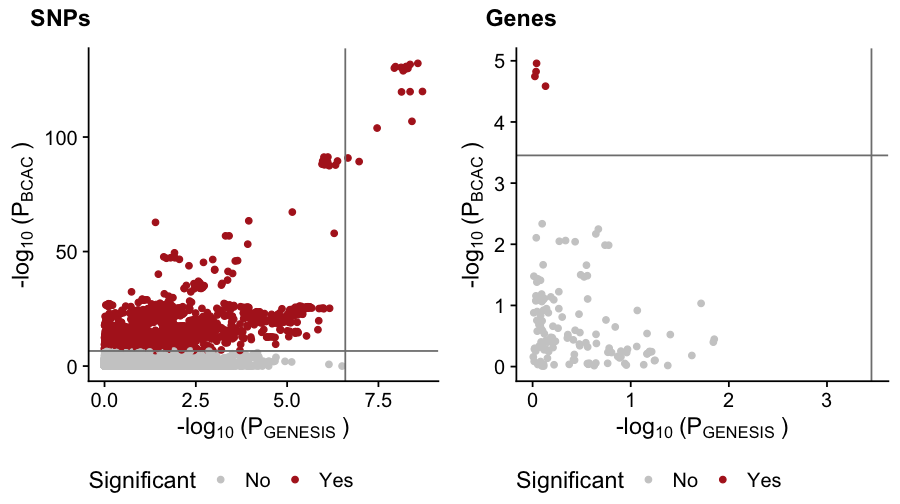

In [4]:
options(repr.plot.width=7.5, repr.plot.height=4.2)
plot_grid(snp_comparison, gene_comparison, labels = c('SNPs', 'Genes'))

LD pruning before Bonferroni

# Comparison to BCAC
## Genes

Parsed with column specification:
cols(
  Uniprot_A = col_character(),
  Uniprot_B = col_character(),
  Gene_A = col_character(),
  Gene_B = col_character(),
  ORF_A = col_character(),
  ORF_B = col_character(),
  Alias_A = col_character(),
  Alias_B = col_character(),
  `pmid:method:quality` = col_character(),
  id = col_double(),
  `Official Symbol Interactor A` = col_character(),
  `Official Symbol Interactor B` = col_character()
)


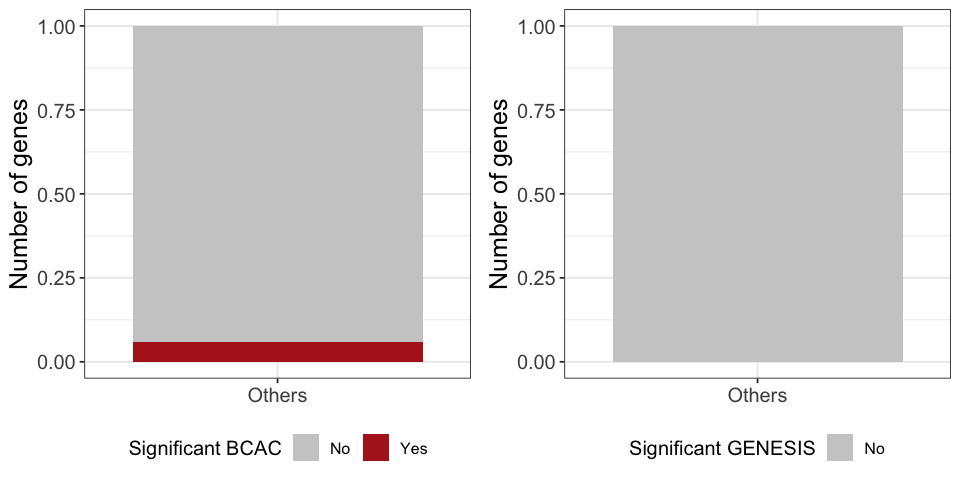

In [5]:
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cllllllii')

# use only genes that can be found in the PPIN
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2')) %>%
    rename(gene_a = `Official Symbol Interactor A`, 
           gene_b = `Official Symbol Interactor B`)
genes_in_ppi <- c(ppi$gene_a, ppi$gene_b)

options(repr.plot.width = 8, repr.plot.height = 4)
genes_bcac <- genes %>%
    filter(Gene %in% genes_in_ppi) %>%
    mutate(selected = ifelse(Gene %in% consensus$name, 'Consensus genes', 'Others')) %>%
    ggplot(aes(x = selected, fill = sign_bcac)) +
        geom_bar(position = 'fill') +
        labs(fill = 'Significant BCAC', y = 'Number of genes') +
        theme_bw() +
        theme(legend.position = 'bottom',
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 15),
              axis.title.x = element_blank(),
              text = element_text(size = 12)) +
        scale_fill_manual(values = palette_yn)

genes_genesis <- genes %>%
    filter(Gene %in% genes_in_ppi) %>%
    mutate(selected = ifelse(Gene %in% consensus$name, 'Consensus genes', 'Others')) %>%
    ggplot(aes(x = selected, fill = sign_genesis)) +
        geom_bar(position = 'fill') +
        labs(fill = 'Significant GENESIS', y = 'Number of genes') +
        theme_bw() +
        theme(legend.position = 'bottom',
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 15),
              axis.title.x = element_blank(),
              text = element_text(size = 12)) +
        scale_fill_manual(values = palette_yn)

plot_grid(genes_bcac, genes_genesis)

## SConES

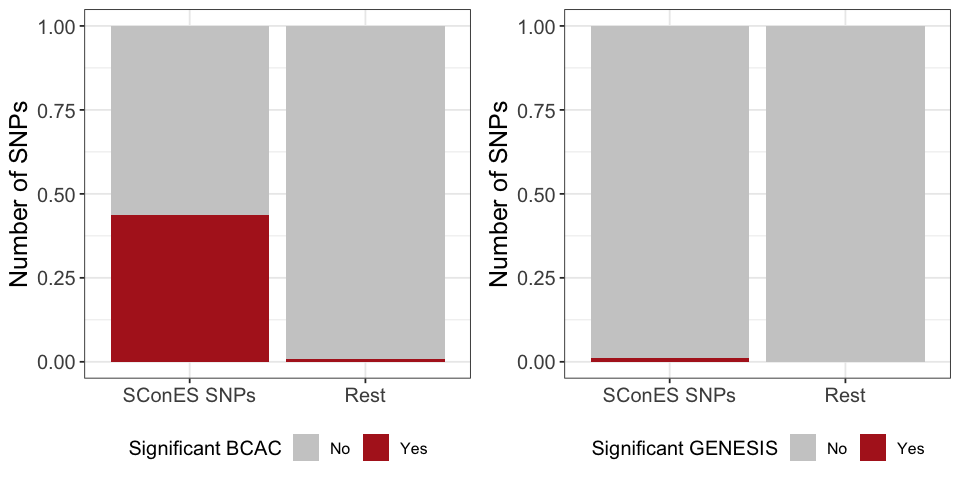

In [6]:
gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp

options(repr.plot.width = 8, repr.plot.height = 4)
snps_bcac <- snps %>%
    mutate(selected = ifelse(SNP %in% gm, 'SConES SNPs', 'Rest'),
           selected = factor(selected, levels = c('SConES SNPs','Rest'))) %>%
    ggplot(aes(x = selected, fill = sign_bcac)) +
        geom_bar(position = 'fill') +
        labs(fill = 'Significant BCAC', y = 'Number of SNPs') +
        theme_bw() +
        theme(legend.position = 'bottom',
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 15),
              axis.title.x = element_blank(),
              text = element_text(size = 12)) +
        scale_fill_manual(values = palette_yn)

snps_genesis <- snps %>%
    mutate(selected = ifelse(SNP %in% gm, 'SConES SNPs', 'Rest'),
           selected = factor(selected, levels = c('SConES SNPs','Rest'))) %>%
    ggplot(aes(x = selected, fill = sign_genesis)) +
        geom_bar(position = 'fill') +
        labs(fill = 'Significant GENESIS', y = 'Number of SNPs') +
        theme_bw() +
        theme(legend.position = 'bottom',
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 15),
              axis.title.x = element_blank(),
              text = element_text(size = 12)) +
        scale_fill_manual(values = palette_yn)

plot_grid(snps_bcac, snps_genesis)